# Simple transformer example

In [1]:
# Standard libraries
import os
import sys
import math

# PyTorch, TorchVision, Lightning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import lightning.pytorch as pl

# datacube related
import xarray as xr

# additional libraries
import pynvml
pynvml.nvmlInit()
import seaborn as sns

## Transformer structure

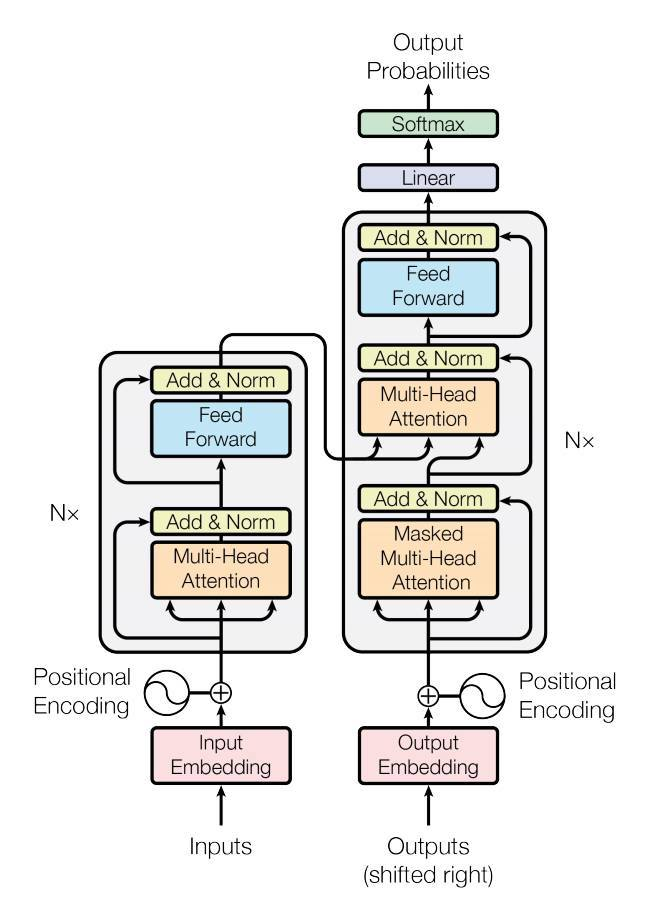

## New layers for transformers

Because transformers need some special way of data preparation and also the attention mechanism, we need to create some new layers for the transformer.

Some explanation:

- **d_model**: the dimension of the embedding vector. In case of time series data this is the number of features.
- 

## Positional encoding and embedding

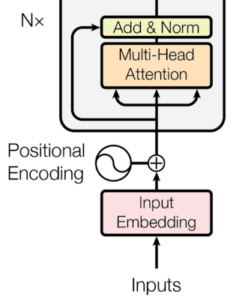

### Positional encoding

The inputs are time series data and therefore has order. The positional encoding is responsible to encode this order because there is no recurrence or convolution in the transformer architecture. In the future there will be probably very complex encoding ideas but so far we want to keep it simple. The positional encoding is a simple sine and cosine function with different frequencies. The frequencies are calculated by the formula:

$$f_{i} = \frac{1}{10000^{\frac{2i}{d_{model}}}}$$

where $i$ is the position and $d_{model}$ is the dimension of the model. The positional encoding is then calculated by:

$$PE_{(pos,2i)} = sin(pos \cdot f_{i})$$
$$PE_{(pos,2i+1)} = cos(pos \cdot f_{i})$$

other ideas for positional encoding:

- Time2Vec as learnable encoding (https://arxiv.org/pdf/1907.05321.pdf)
- ?? Fourier encoding (https://arxiv.org/pdf/2006.10739.pdf)
- 

### Possible other encodings and embeddings

The embedding layer is responsible to transform the input data into the embedding space. The embedding space is a vector space where the data is represented. Depending on the input data there are different ways to create the embedding space. For example for text data there is the word2vec embedding. For time series data there are different ways to create the embedding space:

- Using the input data as embedding space (simple copy of the input data)
- Use a linear layer to create the embedding space (encoder style)

Also the embedding layer should apply the positional encoding to the input data.

The embedding layer is not a preprocessing layer. It is a layer in the transformer architecture.

torch.Size([1, 100, 512])


<Axes: >

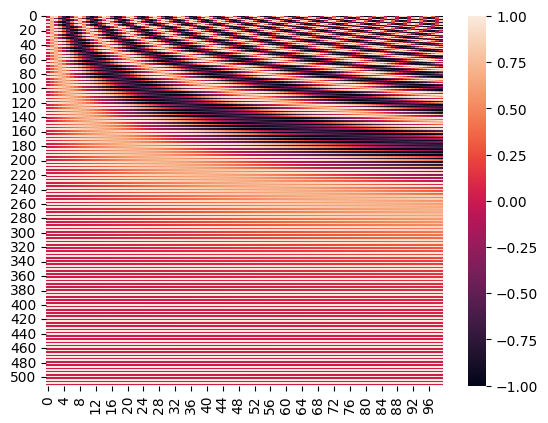

In [2]:
# One dimensional positional encoder layer for the transformer based on "Attention is all you need"
class SimplePositionalEncodingLayer(nn.Module):
    
    def __init__(self, sequence_length, d_model, hw_device = "cpu", position_number = 10000):
        super().__init__()
        self.position_number = position_number
        self.d_model = d_model
        self.sequence_length = sequence_length
        self.hw_device = hw_device

    def forward(self):
        """
        :param Tensor[batch_size, seq_len, d_model] input_sequences
        :return Tensor[batch_size, seq_len, d_model] position_encoding
        """
        
        positions = torch.arange(self.sequence_length).unsqueeze(1).to(self.hw_device)
        exponents = (torch.arange(self.d_model) / self.d_model).float().unsqueeze(0).to(self.hw_device)
        position_references = positions / torch.pow(self.position_number, exponents).to(self.hw_device)
        position_references[:, 0::2] = torch.sin(position_references[:, 0::2]) # apply sin to even indices in the tensor; 2i
        position_references[:, 1::2] = torch.cos(position_references[:, 1::2]) # apply cos to odd indices in the tensor; 2i
        position_encoding = position_references.unsqueeze(0) # [batch_size, seq_len, d_model]
        return position_encoding

# Example, 100 time steps with 12 features each
print(SimplePositionalEncodingLayer(100,512)().shape)
sns.heatmap(SimplePositionalEncodingLayer(100,512)()[0,:,:].T)

In [3]:
class InputEmbeddingAndPositionalEncodingLayer(nn.Module):

    def __init__(self, dropout = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, sequences):
        """
        :param Tensor[batch_size, seq_len, d_model] sequences
        :return Tensor[batch_size, seq_len, d_model] output
        """
        
        encoding_layer = SimplePositionalEncodingLayer(sequences.size(1), sequences.size(2))()
        
        embedded_sequence = sequences
        embedded_sequence = self.dropout(embedded_sequence)
        output = embedded_sequence + encoding_layer
        
        return output

#torch.manual_seed(0)
x = torch.randn(2,4,12)
InputEmbeddingAndPositionalEncodingLayer()(x).shape

torch.Size([2, 4, 12])

## Transformer encoder stack

The next part is to use the transformer encoder stack. The encoder stack is a stack of encoder layers. Each encoder layer has a multi head attention layer and a feed forward layer. The output of the encoder stack is the output of the transformer.

important parameters:

- **num_layers**: number of encoder layers
- **nheads**: number of heads in the multi head attention layer
- **batch_first**: if the batch dimension is the first dimension of the input data

In [4]:
# Encoder Layer for the transformer based on "Attention is all you need"

input = torch.randn(2, 4, 12) # [batch_size, seq_len, features]

encoder = nn.TransformerEncoderLayer(d_model=input.size(2), nhead=1, batch_first=True)
encoder_stack = nn.TransformerEncoder(encoder, num_layers=6)

encoder_stack(input).shape


torch.Size([2, 4, 12])

## Task specification

Now it's important to specify the task. The task is to predict the next value of the time series. Therefore the output dimension is 1. We also put everything into a complete model class.

In [5]:
class SimpleTransformerForecast(nn.Module):
    
    def __init__(self, d_model, nhead, num_layers, dropout = 0.1):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.input_layer = InputEmbeddingAndPositionalEncodingLayer(dropout=dropout)
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout), num_layers=num_layers)
        self.flatten = nn.Flatten()
        self.output_layer = nn.Linear(d_model, 1) 
        
    def forward(self, input_sequences):
        """
        :param Tensor[batch_size, seq_len, d_model] input_sequences
        :return Tensor[batch_size, seq_len, d_model] output
        """
        
        result_input = self.input_layer(input_sequences)
        result_latent = self.encoder(result_input)
        output = self.output_layer(result_latent)
        return output

x = torch.randn(2,4,8)

SimpleTransformerForecast(8,1,1)(x).shape
        

torch.Size([2, 4, 1])